# c-VAE Model Inference for MALDI data

This notebook demonstrates the capability of the trained Conditional Variational Autoencoder (c-VAE) model on MALDI mass spectrometry imaging data.

## Inference Pipeline Overview:
1. Load the data and trained model
2. Visualise the results after reconstruction with the c-VAE model
3. Save the reconstructed fields

In [1]:
# Import required libraries
import os
import torch
import json
import numpy as np
from pathlib import Path
import logging
import matplotlib.pyplot as plt
import scipy.stats as stats

os.chdir('/home/pasco/sdsc_mlibra/JupyterNotebooks/cleaned/brain_lipid_cvae_pcorso') # Replace with the path where you git-cloned the repo

# Import our modules
from models.cvae import ConditionalVAE
from utils.dataloader import read_h5_coordinates, read_h5_matrix, MALDIDataset, create_dataloader
from utils.visualisation import TrainingVisualizer, ReconstructionVisualizer

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Load data for reconstruction and error evaluation

Load the trained model and coordinate arrays for inference

In [2]:
runID_path = Path('training_plots')
runID_filepath = runID_path / 'runID.txt'

with open(runID_filepath, 'r') as f:
    data = json.loads(f.readline())
    run_id = str(data)
    
data_dir = Path('data/H5')
coords_path = data_dir / 'coords_complete.h5'
ref_path = data_dir / 'reference_data.h5'
indices_path = data_dir / 'indices_zeroedout.h5'
model_path = Path('checkpoints/',run_id,'best_model.pt')
coords = read_h5_coordinates(coords_path)
refData = read_h5_matrix(ref_path).reshape(1, -1)
indices_zeroedout = read_h5_matrix(indices_path)
print(indices_zeroedout.shape)

INFO:root:Number of points: 47968
INFO:root:Matrix shape: (47968,)
INFO:root:Matrix data type: float64
INFO:root:Matrix shape: (22283,)
INFO:root:Matrix data type: int64


(22283,)


In [3]:
@torch.no_grad()
def load_and_predict(model_path, coords_inf, refData_inf, n_inf_full_pass, plot_errors, device="cpu", noise=None):
    """
    Load saved model parameters and generate reconstructed spatial distribution
        
    Args:
        model_path: Path to the saved model file (best_model.pt)
        coords: Coordinates tensor [3, n_spatial_points]
        device: Device to run the model on ("cuda" or "cpu")
        noise: Optional pre-defined noise tensor [1, latent_dim]
    
    Returns:
        mu_inf: Reconstructed mean spatial distribution [1, n_spatial_points]
        logvar_inf: Log variance of the reconstruction [1, n_spatial_points]
        model: Loaded model instance
    """
    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract model configuration from checkpoint
    z_dim = checkpoint['z_dim']
    
    # Create model instance with same configuration
    # You'll need to provide these dimensions from your training configuration
    maldi_dim = coords.shape[-1]  # n_spatial_points
    ccf_dim = coords.shape[1]    # n_coordinated
    hidden_dim = 512  # Use the same hidden_dim as the one used during training
    
    # Initialize model
    model = ConditionalVAE(
        maldi_dim=maldi_dim,
        ccf_dim=ccf_dim,
        hidden_dim=hidden_dim,
        latent_dim=z_dim,
        device=device
    )
    
    # Load the saved parameters
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Move model to device and set to eval mode
    model = model.to(device)
    model.eval()
    
    # Move coords to device
    coords_inf = coords_inf.to(device)
    
    # Generate reconstruction
    mu_inf, reconstruction_errors, fig = model.predict_with_coordinates_multiple_passes(coords_inf, refData_inf, n_inf_full_pass, plot_errors, noise)
        
    return mu_inf, reconstruction_errors, model, fig

/tmp/ipykernel_55177/940547684.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Iteration 1/40, Mean Error: 0.029363
Iteration 2/40, Mean Error: 0.029809
Iteration 3/40, Mean Error: 0.029488
Iteration 4/40, Mean Error: 0.029689
Iteration 5/40, Mean Error: 0.029484
Iteration 6/40, Mean Error: 0.029473
Iteration 7/40, Mean Error: 0.029505
Iteration 8/40, Mean Error: 0.029311
Iteration 9/40, Mean Error: 0.029601
Iteration 10/40, Mean Error: 0.029680
Iteration 11/40, Mean Error: 0.029372
Iteration 12/40, Mean Error: 0.029509
Iteration 13/40, Mean Error: 0.029503
Iteration 14/40, Mean Error: 0.029875
Iteration 15/40, Mean Error: 0.029676
Iteration 16/40, Mean Error: 0.029677
Iteration 17/40, Mean Error: 0.029695
Iteration 18/40, Mean Error: 0.029472
Iteration 19/40, Mean Error: 0.029492
Iteration 20/40, Mean Error: 0.029455
Iteration 21/40, Mean Error: 0.029684
Iteration 22/40, Mean Error: 0.029475
Iteration 23/40, Mean Error: 0.029629
Iteration 24/40, Mean Error: 0.029506
Iteration 25/40, Mean Error: 0.029452
Iteration 26/40, Mean Error: 0.029711
Iteration 27/40, Mean

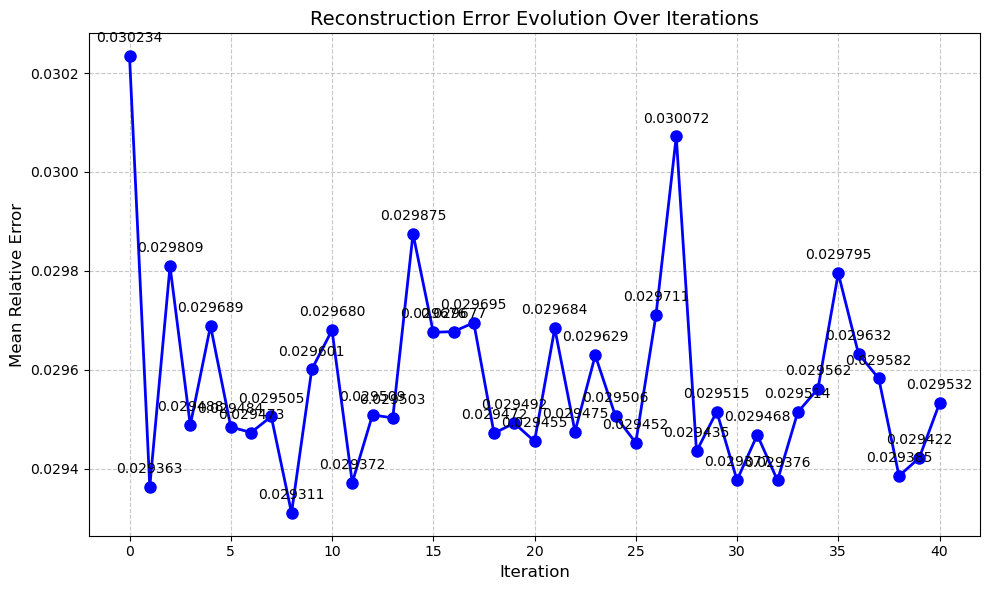

In [4]:
coords_inf = torch.tensor(coords).float()
coords_inf = coords_inf.unsqueeze(0) # Your coordinate data
refData_inf = torch.tensor(refData).float()
mu_inf, error_recon, loaded_model, fig_error_recon = load_and_predict(model_path, coords_inf, refData_inf, n_inf_full_pass=40, plot_errors=True)

## 2. Create the graphs allowing for evaluating the reconstruction quality

Compare the reconstruction with the reference data

In [5]:
def plot_reconstruction_comparison(mu_infs, refDatas, labels=None, colors=None):
    """
    Create a scatter plot comparing multiple reconstructed datasets against reference data
    
    Parameters:
    mu_infs (list): List of reconstructed data arrays from VAE [each 1, n_features]
    refDatas (list): List of reference/observed data arrays [each 1, n_features]
    labels (list): Optional list of labels for each dataset
    colors (list): Optional list of colors for each dataset
    """
    # Set default colors if none provided
    if colors is None:
        colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    # Set default labels if none provided
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(mu_infs))]
    
    # Create the plot
    plt.figure(figsize=(8, 8))
    
    # Find global min and max for the diagonal line
    all_mins = []
    all_maxs = []
    
    # Plot each dataset
    for i, (mu_inf, refData) in enumerate(zip(mu_infs, refDatas)):
        # Convert torch tensor to numpy array if needed
        if isinstance(mu_inf, torch.Tensor):
            mu_inf = mu_inf.detach().cpu().numpy()
        
        # Flatten arrays if needed
        mu_inf = mu_inf.flatten()
        refData = refData.flatten()
        
        # Store mins and maxs
        all_mins.extend([refData.min(), mu_inf.min()])
        all_maxs.extend([refData.max(), mu_inf.max()])
        
        # Create scatter plot
        plt.scatter(refData, mu_inf, alpha=0.5, color=colors[i % len(colors)],
                   label=f'{labels[i]} (r={stats.pearsonr(refData, mu_inf)[0]:.3f})')
    
    # Add perfect reconstruction line (y=x)
    min_val = min(all_mins)
    max_val = max(all_maxs)
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', 
             label='Perfect reconstruction')
    
    # Add labels and title
    plt.xlabel('Reference Data')
    plt.ylabel('Reconstructed Data')
    plt.title('Reconstruction Comparisons')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Make plot square with equal axes
    plt.axis('square')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    return plt

def plot_reconstruction_comparison_loglog(mu_infs, refDatas, labels=None, colors=None, epsilon=1e-10):
    """
    Create a log-log scatter plot comparing multiple reconstructed datasets against reference data,
    excluding values below the threshold epsilon.
    
    Parameters:
    mu_infs (list): List of reconstructed data arrays from VAE [each 1, n_features]
    refDatas (list): List of reference/observed data arrays [each 1, n_features]
    labels (list): Optional list of labels for each dataset
    colors (list): Optional list of colors for each dataset
    epsilon (float): Threshold below which values will be excluded from the plot
    """
    # Set default colors if none provided
    if colors is None:
        colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    # Set default labels if none provided
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(mu_infs))]
    
    # Create the plot
    plt.figure(figsize=(8, 8))
    
    # Find global min and max for the diagonal line
    all_mins = []
    all_maxs = []
    
    # Plot each dataset
    for i, (mu_inf, refData) in enumerate(zip(mu_infs, refDatas)):
        # Convert torch tensor to numpy array if needed
        if isinstance(mu_inf, torch.Tensor):
            mu_inf = mu_inf.detach().cpu().numpy()
        
        # Flatten arrays if needed
        mu_inf = mu_inf.flatten()
        refData = refData.flatten()
        
        # Filter out values below epsilon in either dataset
        valid_indices = (np.abs(mu_inf) > epsilon) & (np.abs(refData) > epsilon)
        mu_inf_filtered = mu_inf[valid_indices]
        refData_filtered = refData[valid_indices]
        
        # Skip if no valid points remain
        if len(mu_inf_filtered) == 0:
            print(f"Warning: No valid points above epsilon threshold for dataset {labels[i]}")
            continue
        
        # Take absolute values for log plotting
        mu_inf_pos = np.abs(mu_inf_filtered)
        refData_pos = np.abs(refData_filtered)
        
        # Store mins and maxs
        all_mins.extend([refData_pos.min(), mu_inf_pos.min()])
        all_maxs.extend([refData_pos.max(), mu_inf_pos.max()])
        
        # Calculate correlation using original (filtered) values
        correlation = stats.pearsonr(refData_filtered, mu_inf_filtered)[0]
        
        # Create log-log scatter plot
        plt.loglog(refData_pos, mu_inf_pos, '.', alpha=0.5, 
                  color=colors[i % len(colors)],
                  label=f'{labels[i]} (r={correlation:.3f}, n={len(mu_inf_filtered)})')
    
    # Add perfect reconstruction line (y=x)
    if all_mins and all_maxs:  # Check if we have any valid points
        min_val = min(all_mins)
        max_val = max(all_maxs)
        plt.loglog([min_val, max_val], [min_val, max_val], 'k--', 
                   label='Perfect reconstruction')
    
        # Add labels and title
        plt.xlabel('Reference Data (log scale)')
        plt.ylabel('Reconstructed Data (log scale)')
        plt.title(f'Log-Log Reconstruction Comparisons (ε={epsilon:.0e})')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Make plot square with equal axes
        plt.axis('square')
        plt.grid(True, linestyle='--', alpha=0.7)
    else:
        plt.close()
        raise ValueError("No valid data points above epsilon threshold")
    
    return plt


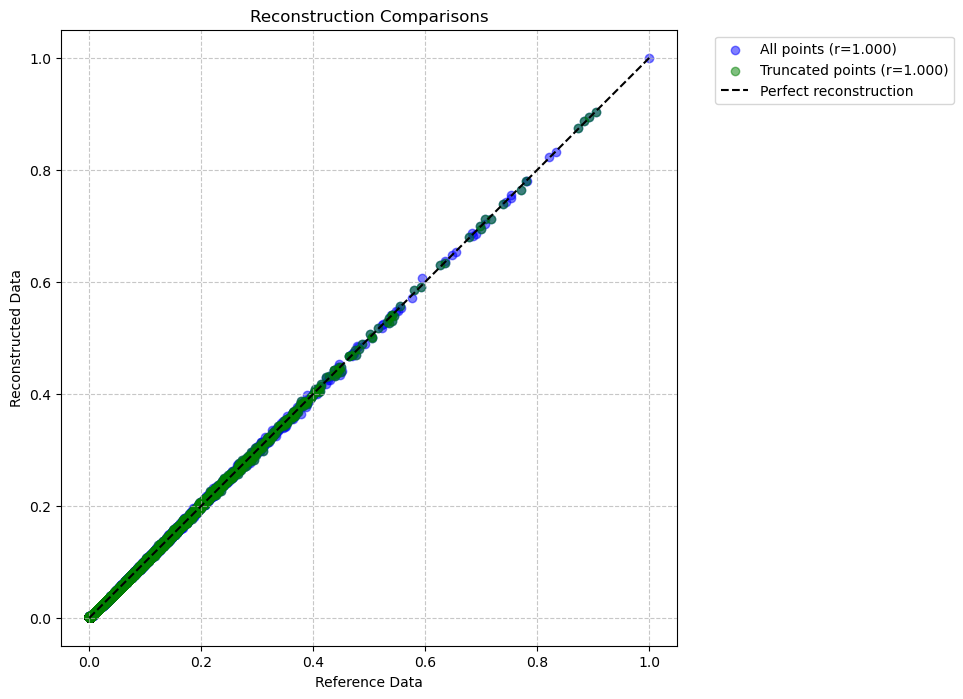

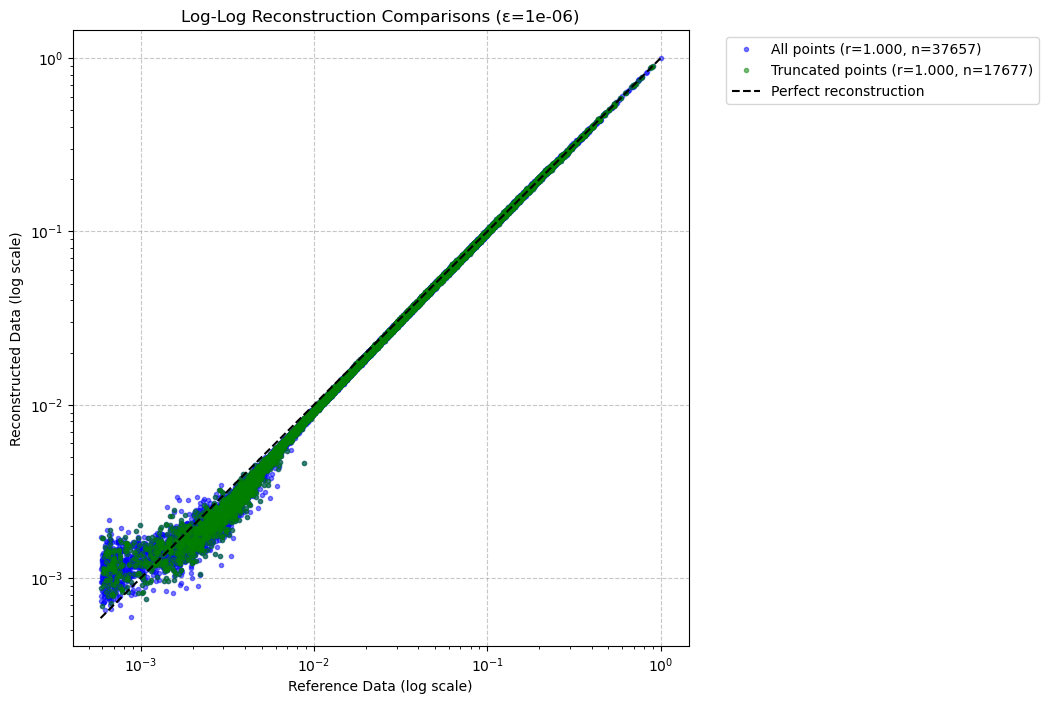

In [6]:
plot_path_base = Path('checkpoints/',run_id)
# linear plot generation for comparison of the reconstruction
mu_infs_list = [mu_inf, mu_inf[:, indices_zeroedout]]  # List of reconstructions
refDatas_list = [refData, refData[:, indices_zeroedout]]  # List of references
labels_list = ['All points', 'Truncated points']  
colors_list = ['blue', 'green'] 

plt = plot_reconstruction_comparison(
    mu_infs_list, 
    refDatas_list,
    labels=labels_list,
    colors=colors_list
)
plot1_filename = plot_path_base / 'scatterError_reconObs_TruncatedvsFullData.png'
plt.savefig(plot1_filename, dpi='figure', bbox_inches='tight', pad_inches=0.1)
plt.show()

# log-log plot generation for comparison of the reconstruction

mu_infs_list = [mu_inf, mu_inf[:, indices_zeroedout]]  # List of reconstructions
refDatas_list = [refData, refData[:, indices_zeroedout]]  # List of references
labels_list = ['All points', 'Truncated points']  
colors_list = ['blue', 'green']  

plt = plot_reconstruction_comparison_loglog(
    mu_infs_list, 
    refDatas_list,
    labels=labels_list,
    colors=colors_list,
    epsilon=1e-6
)
plot2_filename = plot_path_base / 'scatterError_reconObs_TruncatedvsFullData_loglog.png'
plt.savefig(plot2_filename, dpi='figure', bbox_inches='tight', pad_inches=0.1)
plt.show()

## 3. Visualise the results after reconstruction with the c-VAE model

Data saved in TXT files for external visualisation (e.g. in ParaView)

In [ ]:
def spherical_to_cartesian(r, theta, phi):
    """
    Convert spherical coordinates to Cartesian coordinates
    r: radial distance
    theta: polar angle (in radians) from z-axis (0 ≤ θ ≤ π)
    phi: azimuthal angle (in radians) in x-y plane from x-axis (0 ≤ φ ≤ 2π)
    """
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return x, y, z

xCart, yCart, zCart = spherical_to_cartesian(coords[0,:], coords[1,:], coords[2,:])
np.savetxt(plot_path_base / 'refDataTruncated.txt',refData[:,indices_zeroedout].reshape(-1, 1))
np.savetxt(plot_path_base / 'xTruncated.txt',(xCart[indices_zeroedout].reshape(-1, 1)))
np.savetxt(plot_path_base / 'yTruncated.txt',(yCart[indices_zeroedout].reshape(-1, 1)))
np.savetxt(plot_path_base / 'zTruncated.txt',(zCart[indices_zeroedout].reshape(-1, 1)))
np.savetxt(plot_path_base / 'reconValueTruncated.txt',mu_inf[:,indices_zeroedout].reshape(-1, 1))

## Summary

Visualisation steps completed:

1. ✓ Load the data and trained model
2. ✓ Visualise the results after reconstruction with the c-VAE model
3. ✓ Save the reconstructed fields

The trained model is now evaluated and reconstruction can be employed